## Binary language detection using character frequency analysis

In [1]:
import re
import string
import pandas as pd
from math import log
import os
import random
import re
import string
from collections import Counter
from sklearn.cluster import KMeans

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")
nltk.download("stopwords")


SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to /Users/joker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reading a set of 100K randomly picked grievances

In [2]:
#df = pd.read_csv(r"/Users/joker/Thesis/data/chunk0.csv")
df = pd.read_csv(r"../data_100k.csv")
df = df.loc[:, ['description']]



### Sample of read data

In [3]:
df

,description
0,"Respected Sir &amp; Madam,I have applied for t..."
1,"Dear Prime Minister,What I am asking for is th..."
2,"Dear Prime Minister, I have enclosed a data sh..."
3,Sir mai virendra pratap singh uttar pradesh ka...
4,"Hello Sir,I am Mr. Kishor Punamchand Dave aged..."
...,...
99995,"Dear Modi Ji, Me and my family&#39;s greetings..."
99996,"Namaste Ji,Myself A.Kamalakannan working in a ..."
99997,Respected PMMy father purchase 1st new car in ...
99998,"Respected Sir,Greetings,I am a female student ..."


### Clean_text is a function defined to remove unnecessary things like extra spaces, punctuation, numbers etc from the text

In [4]:
def freq1(sent):
    tmp = {}
    for letter in sent:
        if 97 <= ord(letter) <= 122:
            # print("here")
            try: 
                tmp[letter]+=1
            except:
                tmp[letter]=1 
    #arr[::-1].sort()
    
    tmp = { k:v for k,v in sorted(tmp.items(), key=lambda x: x[1], reverse=True) }
    return tmp 

In [5]:
def clean_text(text):
    text = str(text).lower() 
    text = re.sub(r"\[(.*?)\]", "", text)  
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text) 
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text) 
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation
    text = re.sub('[^a-z\s]+', '', text)
    return text

In [6]:
df['description_cleaned'] = df['description'].apply(clean_text)

In [7]:
len(df)

100000

### Removing cleaned grievances having 0 length

In [8]:
df = df.loc[df.description_cleaned.map(lambda x: len(x) > 0), :]

In [9]:
len(df)

99995

### Sample of cleaned data

In [10]:
df.description_cleaned

0        respected sir amp madami have applied for the ...
1        dear prime ministerwhat i am asking for is tha...
2        dear prime minister i have enclosed a data she...
3        sir mai virendra pratap singh uttar pradesh ka...
4        hello siri am mr kishor punamchand dave aged  ...
                               ...                        
99995    dear modi ji me and my familys greetings and b...
99996    namaste jimyself akamalakannan working in a pr...
99997    respected pmmy father purchase st new car in a...
99998    respected sirgreetingsi am a female student of...
99999    m pichle  year se preparation kr rhi hu par ss...
Name: description_cleaned, Length: 99995, dtype: object

### "freq" function creates a _normalised_ vector of size 26(lower case English letters) for each of the cleaned grievances

In [11]:
def freq(sent):
    arr = np.zeros(26)
    for letter in sent:
        if 97 <= ord(letter) <= 122:
            # print("here")
            arr[ord(letter) - 97] += 1 
    #arr[::-1].sort()
    
    return arr / np.linalg.norm(arr) #normalization

In [12]:
df['histograms'] = df['description_cleaned'].apply(freq)

### Normalised vectors


In [13]:
df.histograms[0]

array([0.39573372, 0.05791225, 0.15443267, 0.14478063, 0.41503781,
       0.05791225, 0.04826021, 0.12547655, 0.33782147, 0.        ,
       0.        , 0.12547655, 0.14478063, 0.23164901, 0.25095309,
       0.20269288, 0.00965204, 0.27025718, 0.33782147, 0.27990922,
       0.13512859, 0.02895613, 0.04826021, 0.        , 0.07721634,
       0.        ])

> NOTE: Create TSNE plots

### Applying K Means 

In [14]:
clusters = 2

In [15]:
def mbkmeans_clusters(X, k):
    km = KMeans(n_clusters=k).fit(X)
    return km.labels_

### Checking if the code has any NA values


In [16]:
df.isna().sum()

description            0
description_cleaned    0
histograms             0
dtype: int64

### Removing the NA values if found

In [17]:
df = df.loc[ df.histograms.map(lambda x: ~np.isnan(x).any()), :]

In [18]:
len(df)

99995

### Applying KMeans to the normalissed frequency distributions and extracting the cluster labels

In [19]:
cluster_labels = mbkmeans_clusters(
	X=list(df['histograms'].values),
    k=clusters,
)

In [20]:
df_clusters = pd.DataFrame({
    
    "text": df['description'].values,
    #"histograms" : df['histograms'].values,
    "cluster": cluster_labels
})

In [21]:
df_clusters

,text,cluster
0,"Respected Sir &amp; Madam,I have applied for t...",0
1,"Dear Prime Minister,What I am asking for is th...",0
2,"Dear Prime Minister, I have enclosed a data sh...",0
3,Sir mai virendra pratap singh uttar pradesh ka...,1
4,"Hello Sir,I am Mr. Kishor Punamchand Dave aged...",0
...,...,...
99990,"Dear Modi Ji, Me and my family&#39;s greetings...",0
99991,"Namaste Ji,Myself A.Kamalakannan working in a ...",0
99992,Respected PMMy father purchase 1st new car in ...,0
99993,"Respected Sir,Greetings,I am a female student ...",0


In [22]:
for i in range(clusters):
    print(i, len(df_clusters[df_clusters.cluster == i]))

0 87904
1 12091


In [23]:
for i in range(clusters):
    df_clusters[df_clusters.cluster == i].to_csv(str(i)+ ".csv")

## Plots and Inference

#### Predicted Hindi



Sir mujhse lgta h humrahe desh  mai medicine h... Kuch din phle ki baat h .. Meri nana ke ghr sbko corona ho gaya tha par nani ko corona nhi hua tha jbki humrahe doctor sb ppe kit m rhte h tv v unko corona ho jata h..... But meri nani ko kuch nhi hua bine mask ke ghum rahi thi.....kyuki sbko corona hone se phle nani ko monkey na kat liya tha toh unko uski injection lgai thi ... Toh isliye mujhse lgta h... Monkey wali vaccination shyd hume corona mai harne mai help kare..... Isliye m chata hu ki... Ispe ek research ho... Kya pta isse humraha desh ka bhala ho jaye ... Mujhse lgta aesa lgta h.... Agr ho ske plz ek bar research kara kr dekh lena .... ???


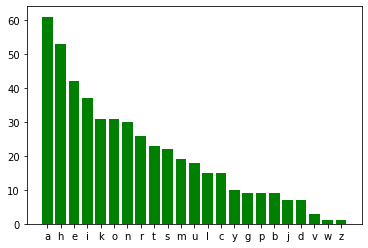

Bengal jis tarah dangai ho raha hai muslim ke duwara hindu ko rape or ghar jalaye ja rahe hai..kiya central govt chup kyu hai hindu ko bachana chahiye and bjp leader ko murder kiya ja raha hai..aise chup rahne se kuch ni hoga hindu samaj khatre me hai ..please I request you aap Bengal rastpari sasan laga dijiye ya to khud ja ke investigation kijiye..mamta sarkar ko hota kr acha ek sarkar ko baitha dijiye..ni to bjp se sabhi hindu se wiswas hat jayega..


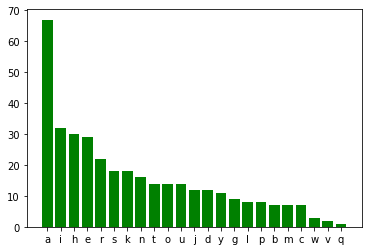

Sir, maine aap ko khat likha tha. Jis me mai mapni majburi ko batya tha. Kyoki mai akela  hu,because I loss my father 2011.but aap ne some sentence me mere sahara ko nisahara  bana diya because mera letter clear nahi hai. Mai one month se esi hospital ka chaker kat raha hu but nobody can take aney action for a dangerous  like cancer diesies. My mom is last stage plese help me. Otherwise I also loss my mom please sir help me. Thanks


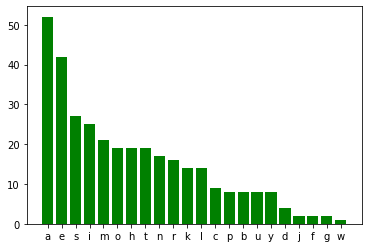

In [24]:

from matplotlib import pyplot as plt

for i in [104, 262, 8282]:
    print(df[df.index == i].description.values[0])
    data =  freq1(df[df.index == i].description_cleaned.values[0])
    plt.bar(list(data.keys()), data.values(), color='g')
    plt.show()


### Predicted English

To, Honourable Prime MinisterSub: Cancellation of premature retirement order dated 12.12.2017 issued by DoWR RD GR under CCS (Pension) Rules, 1972 – regarding Sir, I once again request immediate cancellation of premature retirement order dated 12.12.2017 issued under CCS (Pension) Rules, 1972 by DoWR RD GR since Department has failed to ensure pension payment in pursuance of premature retirement order dated 12.12.2017 issued by them under CCS Pension, Rules 1972 even after a lapse of more than three and half years despite receipt of SSA on basis of post retirement regularization of conditional transfer tenure 2012-2017 in contravention of provisions under CCS (Pension) Rules 1972 without approval of President of India from CPAO in CPPC, Patna on 19.04.2021.Yours faithfully, L. P. Singh, Director, GFCC, Patna* *as per biometric attendance of GFCC, Patna Copy to:- 1. Secretary, DOWR RD GR, Jal Shakti Ministry, GoI 2. Additional Secretary, DoWR RD GR, GoI 3. Joint Secretary (Admn.), DoWR 

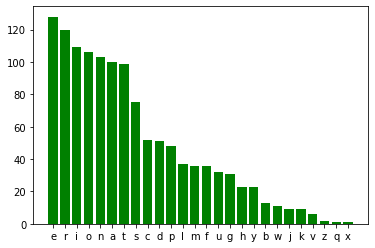

Letter to Finance Minister on Banking Services.We addressed a letter to the Union Finance Minister today on the captioned subject. Text of the letter is appended below, which is self explanatory.Consequent upon merger of 10 public sector banks into 4, effected from 1st April 2020, the services of the banks have undergone serious deterioration due to imposition of the decision as announced by your good office on 30th Aug. 2019 notwithstanding ground realities and inept handling of the situation by the apex managements of respective banks.We are coming across information that following premature system integration in the merged entities implemented without proper infrastructural support, several necessary functions like cash receipts, cash payments, pass book issuance/updation, issuance of various statements/certificates, loan sanctioning and related documentation are seriously jeopardised. The employees and officers, on daily basis, are forced to sit late for completion of their daily j

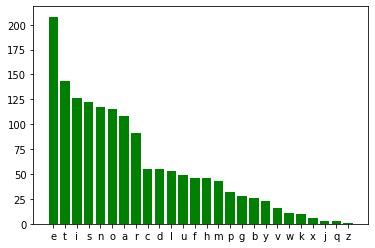

Namaste Prime MinisterJI,I am a big fan of you and under your supervision, I have experienced lot of changes in India. I wish that you can continue to govern India for many many years. I must congratulate on your many achievements.Sirji, Today I experienced a very inefficient process while researching/understanding for renewing my Kids OCI cards. One of my kid is Minor-under 18 and other one is 19 years old. After spending 5 hours on various website like VFS.Global(https://visa.vfsglobal.com/usa/en/ind) ,  Sans Francisco consulate website and https://ociservices.gov.in/,  I still could not figure out what exact documents needed to renew my kids passport.The information is flying all across with no consistency. The document list they say is generic and do not break down for renewal of OCI, minor etc. The whole process is so cumbersome that many of my friends had dropped the application in past (including me last year). And we cannot talk to anyone to guide us except VFS Global who wants

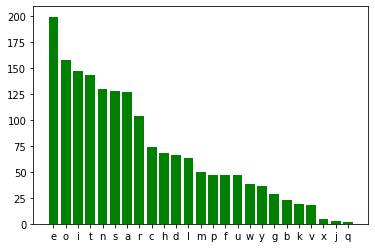

In [25]:
from matplotlib import pyplot as plt

for i in [1975, 2180, 1500]:
    print(df[df.index == i].description.values[0])
    data =  freq1(df[df.index == i].description_cleaned.values[0])
    plt.bar(list(data.keys()), data.values(), color='g')
    plt.show()